<a href="https://colab.research.google.com/github/justn-hyeok/BigdataProject/blob/main/Spotify_%EC%9D%8C%EC%95%85_%EC%B7%A8%ED%96%A5_%EB%B6%84%EC%84%9D%EA%B8%B0_2116%ED%99%A9%EC%A4%80%ED%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spotipy plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
!apt-get install -y fonts-nanum
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (32.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [ ]:
import os
import sys
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
from collections import Counter

import spotipy
from spotipy.oauth2 import SpotifyOAuth

# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.offline as pyo
# pyo.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print("V 모든 패키지 로드 완료")


V 모든 패키지 로드 완료


In [ ]:
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

print("V 나눔고딕 폰트 설정 완료")

V 나눔고딕 폰트 설정 완료


In [ ]:
class SpotifyConfig:
    """Spotify API 설정 클래스"""

    def __init__(self):
        self.client_id = self._get_client_id()
        self.client_secret = self._get_client_secret()
        self.redirect_uri = "https://127.0.0.1:8888/callback"
        self.scope = self._get_scope()

        # 데이터 수집 제한
        self.recent_tracks_limit = 30
        self.top_tracks_limit = 30
        self.top_artists_limit = 20

    def _get_client_id(self):
        """클라이언트 ID 가져오기"""
        try:
            from google.colab import userdata
            return userdata.get('SPOTIFY_CLIENT_ID')
        except:
            return input("Spotify Client ID 입력: ").strip()

    def _get_client_secret(self):
        """클라이언트 시크릿 가져오기"""
        try:
            from google.colab import userdata
            return userdata.get('SPOTIFY_CLIENT_SECRET')
        except:
            return input("Spotify Client Secret 입력: ").strip()

    def _get_scope(self):
        """API 권한 스코프 정의"""
        return " ".join([
            "user-read-recently-played",
            "user-top-read",
            "user-library-read",
            "user-read-playback-state"
        ])

    def is_valid(self):
        """설정 유효성 검사"""
        return bool(self.client_id and self.client_secret)

In [ ]:
class SpotifyClient:
    """Spotify API 클라이언트"""

    def __init__(self, config):
        self.config = config
        self.sp = None
        self.user_info = None
        self._authenticate()

    def _authenticate(self):
        """Spotify 인증 처리"""
        if not self.config.is_valid():
            print("X API 키가 설정되지 않았습니다")
            return False

        try:
            self._clear_cache()
            auth_manager = self._create_auth_manager()

            print("인증이 필요합니다")
            print("1. 아래 링크를 클릭하세요:")

            auth_url = auth_manager.get_authorize_url()
            print(f"   {auth_url}")

            print("\n2. Spotify에 로그인하고 승인하세요")
            print("3. 리다이렉트된 URL 전체를 복사해서 입력하세요")
            print("   (주의: ?code=... 부분까지 모두 포함해야 함)")

            redirect_response = input("\n리다이렉트된 URL 전체를 입력하세요: ")

            if not self._process_redirect_url(auth_manager, redirect_response):
                return False

            self.sp = spotipy.Spotify(auth_manager=auth_manager)
            self.user_info = self.sp.current_user()

            user_name = self.user_info.get('display_name', '익명')
            print(f"V 연결 성공 안녕하세요, {user_name}님")

            return True

        except Exception as e:
            print(f"X 연결 실패: {e}")
            self._print_troubleshooting()
            return False

    def _clear_cache(self):
        """캐시 파일 삭제"""
        cache_file = ".spotify_cache"
        if os.path.exists(cache_file):
            os.remove(cache_file)
            print("캐시 파일 삭제")

    def _create_auth_manager(self):
        """인증 매니저 생성"""
        return SpotifyOAuth(
            client_id=self.config.client_id,
            client_secret=self.config.client_secret,
            redirect_uri=self.config.redirect_uri,
            scope=self.config.scope,
            cache_path=".spotify_cache",
            open_browser=False,
            show_dialog=True
        )

    def _process_redirect_url(self, auth_manager, redirect_response):
        """리다이렉트 URL 처리"""
        import urllib.parse as urlparse

        parsed_url = urlparse.urlparse(redirect_response)
        code = urlparse.parse_qs(parsed_url.query).get('code')

        if not code:
            print("X URL에서 인증 코드를 찾을 수 없습니다")
            print("전체 URL을 복사했는지 확인하세요 (특히 ?code= 부분)")
            return False

        auth_manager.get_access_token(code[0])
        return True

    def _print_troubleshooting(self):
        """문제 해결 가이드 출력"""
        print("해결 방법:")
        print("1. Spotify Developer Dashboard에서 Redirect URI 확인:")
        print("   http://127.0.0.1:8888/callback")
        print("2. 전체 URL을 정확히 복사했는지 확인")
        print("3. 런타임을 재시작하고 다시 시도")


In [ ]:
class SpotifyDataCollector:
    """Spotify 데이터 수집기"""

    def __init__(self, spotify_client, config):
        self.sp = spotify_client.sp
        self.config = config
        self.user_info = spotify_client.user_info

    def collect_all_data(self):
        """모든 데이터 수집"""
        print("데이터 수집 시작...")

        recent_tracks = self._collect_recent_tracks()
        top_tracks = self._collect_top_tracks()
        top_artists = self._collect_top_artists()
        audio_features = self._create_empty_audio_features()

        print("V 모든 데이터 수집 완료")

        return {
            'recent_tracks': recent_tracks,
            'top_tracks': top_tracks,
            'top_artists': top_artists,
            'audio_features': audio_features,
            'user_info': self.user_info
        }

    def _collect_recent_tracks(self):
        """최근 재생 곡 수집"""
        limit = self.config.recent_tracks_limit
        print(f"최근 재생 곡 {limit}개 수집 중...")

        try:
            recent_data = self.sp.current_user_recently_played(limit=limit)
            tracks = []

            for item in recent_data['items']:
                track = item['track']
                track_info = {
                    'track_id': track['id'],
                    'track_name': track['name'],
                    'artist_name': track['artists'][0]['name'],
                    'played_at': item['played_at'],
                    'popularity': track['popularity'],
                    'duration_ms': track['duration_ms']
                }
                tracks.append(track_info)

            df = pd.DataFrame(tracks)
            print(f"V 최근 재생 곡: {len(df)}개")
            return df

        except Exception as e:
            print(f"X 최근 재생 곡 수집 실패: {e}")
            return pd.DataFrame()

    def _collect_top_tracks(self):
        """인기 곡 수집"""
        limit = self.config.top_tracks_limit
        print(f"인기 곡 {limit}개 수집 중...")

        try:
            top_tracks_data = self.sp.current_user_top_tracks(limit=limit)
            tracks = []

            for track in top_tracks_data['items']:
                track_info = {
                    'track_id': track['id'],
                    'track_name': track['name'],
                    'artist_name': track['artists'][0]['name'],
                    'popularity': track['popularity'],
                    'duration_ms': track['duration_ms']
                }
                tracks.append(track_info)

            df = pd.DataFrame(tracks)
            print(f"V 인기 곡: {len(df)}개")
            return df

        except Exception as e:
            print(f"X 인기 곡 수집 실패: {e}")
            return pd.DataFrame()

    def _collect_top_artists(self):
        """인기 아티스트 수집"""
        limit = self.config.top_artists_limit
        print(f"인기 아티스트 {limit}명 수집 중...")

        try:
            top_artists_data = self.sp.current_user_top_artists(limit=limit)
            artists = []

            for artist in top_artists_data['items']:
                artist_info = {
                    'artist_id': artist['id'],
                    'artist_name': artist['name'],
                    'popularity': artist['popularity'],
                    'followers': artist['followers']['total'],
                    'genres': artist['genres']
                }
                artists.append(artist_info)

            df = pd.DataFrame(artists)
            print(f"V 인기 아티스트: {len(df)}명")
            return df

        except Exception as e:
            print(f"X 인기 아티스트 수집 실패: {e}")
            return pd.DataFrame()

    def _create_empty_audio_features(self):
        """빈 오디오 특성 DataFrame 생성"""
        print("오디오 특성: 권한 이슈로 스킵")
        return pd.DataFrame()


In [ ]:
class SpotifyDataAnalyzer:
    """Spotify 데이터 분석기"""

    def __init__(self, data):
        self.data = data
        self.recent_tracks = data['recent_tracks']
        self.top_tracks = data['top_tracks']
        self.top_artists = data['top_artists']
        self.audio_features = data['audio_features']

    def analyze_all(self):
        """전체 분석 실행"""
        print("데이터 분석 중...")

        music_profile = self._create_music_profile()
        listening_patterns = self._analyze_listening_patterns()
        top_genres = self._analyze_top_genres()
        basic_stats = self._calculate_basic_stats()

        print("V 데이터 분석 완료")

        return {
            'music_profile': music_profile,
            'listening_patterns': listening_patterns,
            'top_genres': top_genres,
            'basic_stats': basic_stats
        }

    def _create_music_profile(self):
        """음악 프로필 생성"""
        if self.audio_features.empty:
            print("오디오 특성 없음 - 기본 프로필 생성")
            return {}

        features = [
            'danceability', 'energy', 'valence', 'acousticness',
            'speechiness', 'instrumentalness', 'liveness'
        ]

        profile = {}
        for feature in features:
            if feature in self.audio_features.columns:
                profile[feature] = self.audio_features[feature].mean()

        print("V 음악 프로필 생성")
        return profile

    def _analyze_listening_patterns(self):
        """청취 패턴 분석"""
        if 'played_at' not in self.recent_tracks.columns or self.recent_tracks.empty:
            print("청취 패턴 데이터 없음")
            return None

        df = self.recent_tracks.copy()
        df['played_at'] = pd.to_datetime(df['played_at'])
        df['hour'] = df['played_at'].dt.hour
        df['day'] = df['played_at'].dt.day_name()

        patterns = {
            'hourly': df['hour'].value_counts().sort_index(),
            'daily': df['day'].value_counts()
        }

        print("V 청취 패턴 분석")
        return patterns

    def _analyze_top_genres(self):
        """선호 장르 분석"""
        if 'genres' not in self.top_artists.columns or self.top_artists.empty:
            print("장르 데이터 없음")
            return {}

        all_genres = []
        for genres in self.top_artists['genres']:
            if isinstance(genres, list):
                all_genres.extend(genres)

        if not all_genres:
            return {}

        top_genres = dict(Counter(all_genres).most_common(10))
        print("V 장르 분석")
        return top_genres

    def _calculate_basic_stats(self):
        """기본 통계 계산"""
        stats = {
            'recent_tracks_count': len(self.recent_tracks),
            'top_tracks_count': len(self.top_tracks),
            'top_artists_count': len(self.top_artists),
            'avg_popularity': 0,
            'total_duration_hours': 0
        }

        if not self.top_tracks.empty:
            stats['avg_popularity'] = self.top_tracks['popularity'].mean()
            stats['total_duration_hours'] = (
                self.top_tracks['duration_ms'].sum() / (1000 * 60 * 60)
            )

        print("V 기본 통계 계산")
        return stats


In [ ]:
class SpotifyVisualizer:
    """Spotify Data Visualization (Matplotlib + Seaborn)"""

    def __init__(self, data, analysis_results):
        self.data = data
        self.analysis = analysis_results
        self.user_info = data['user_info']

        # 시각화 세팅
        plt.style.use('default')
        sns.set_style("whitegrid")
        self.colors = {
            'primary': '#1DB954',
            'secondary': '#1ED760',
            'dark': '#191414',
            'light': '#f0f0f0'
        }

    def create_all_visualizations(self):
        """Create all visualizations"""
        print("Creating visualizations...")

        self._create_summary_dashboard()
        self._create_listening_patterns_chart()
        self._create_top_tracks_chart()
        self._create_top_artists_chart()
        self._create_genre_analysis_chart()

        print("V All visualizations created")

    def _create_summary_dashboard(self):
        """Create summary dashboard"""
        user_name = self.user_info.get('display_name', 'Anonymous')
        stats = self.analysis['basic_stats']

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{user_name}\'s Music Taste Analysis', fontsize=20, fontweight='bold')

        # 1. Basic stats bar chart
        categories = ['Total Tracks', 'Artists', 'Recent Plays']
        values = [
            stats['top_tracks_count'],
            stats['top_artists_count'],
            stats['recent_tracks_count']
        ]

        bars = ax1.bar(categories, values, color=[self.colors['primary'], self.colors['secondary'], self.colors['dark']])
        ax1.set_title('Basic Statistics', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Count')

        # Show numbers on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{value}', ha='center', va='bottom', fontweight='bold')

        # 2. Hourly listening pattern
        patterns = self.analysis['listening_patterns']
        if patterns and 'hourly' in patterns:
            hourly = patterns['hourly']
            ax2.bar(hourly.index, hourly.values, color=self.colors['primary'], alpha=0.8)
            ax2.set_title('Hourly Listening Pattern', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Hour')
            ax2.set_ylabel('Play Count')
            ax2.set_xticks(range(0, 24, 4))
        else:
            ax2.text(0.5, 0.5, 'No hourly data available',
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Hourly Listening Pattern', fontsize=14, fontweight='bold')

        # 3. Daily listening pattern
        if patterns and 'daily' in patterns:
            daily = patterns['daily']
            # Sort by day order
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            daily_sorted = daily.reindex(day_order, fill_value=0)

            ax3.bar(range(len(daily_sorted)), daily_sorted.values,
                   color=self.colors['secondary'], alpha=0.8)
            ax3.set_title('Daily Listening Pattern', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Day of Week')
            ax3.set_ylabel('Play Count')
            ax3.set_xticks(range(len(daily_sorted)))
            ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
        else:
            ax3.text(0.5, 0.5, 'No daily data available',
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Daily Listening Pattern', fontsize=14, fontweight='bold')

        # 4. Popularity distribution histogram
        if not self.data['top_tracks'].empty:
            ax4.hist(self.data['top_tracks']['popularity'], bins=15,
                    color=self.colors['primary'], alpha=0.7, edgecolor='black')
            ax4.set_title('Track Popularity Distribution', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Popularity Score')
            ax4.set_ylabel('Number of Tracks')
            ax4.axvline(stats['avg_popularity'], color='red', linestyle='--',
                       label=f'Average: {stats["avg_popularity"]:.1f}')
            ax4.legend()
        else:
            ax4.text(0.5, 0.5, 'No popularity data available',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Track Popularity Distribution', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()
        print("V Summary dashboard displayed")

    def _create_listening_patterns_chart(self):
        """Create detailed listening patterns chart"""
        patterns = self.analysis['listening_patterns']
        if not patterns:
            print("No listening pattern data - skipping chart")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Detailed Listening Pattern Analysis', fontsize=16, fontweight='bold')

        # Hourly pattern (detailed)
        if 'hourly' in patterns:
            hourly = patterns['hourly']

            # Seaborn barplot
            sns.barplot(x=hourly.index, y=hourly.values, ax=ax1, palette='viridis')
            ax1.set_title('Hourly Listening Distribution', fontsize=14)
            ax1.set_xlabel('Hour')
            ax1.set_ylabel('Play Count')

            # Mark peak hour
            peak_hour = hourly.idxmax()
            peak_value = hourly.max()
            ax1.annotate(f'Peak: {peak_hour}h\n({peak_value} plays)',
                        xy=(peak_hour, peak_value),
                        xytext=(peak_hour+2, peak_value+1),
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10, fontweight='bold', color='red')

        # Daily pattern (pie chart)
        if 'daily' in patterns:
            daily = patterns['daily']

            # Color palette
            colors = sns.color_palette('Set3', len(daily))
            wedges, texts, autotexts = ax2.pie(daily.values, labels=daily.index,
                                               autopct='%1.1f%%', colors=colors,
                                               startangle=90)
            ax2.set_title('Daily Listening Distribution', fontsize=14)

            # Text styling
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontweight('bold')

        plt.tight_layout()
        plt.show()
        print("V Detailed listening patterns chart displayed")

    def _create_top_tracks_chart(self):
        """Create top tracks chart"""
        if self.data['top_tracks'].empty:
            print("No top tracks data - skipping chart")
            return

        top_10 = self.data['top_tracks'].head(10)

        plt.figure(figsize=(12, 8))

        # Horizontal bar chart
        bars = plt.barh(range(len(top_10)), top_10['popularity'],
                       color=plt.cm.viridis(np.linspace(0, 1, len(top_10))))

        # Set track names
        plt.yticks(range(len(top_10)),
                  [f"{row['track_name'][:20]}..." if len(row['track_name']) > 20
                   else row['track_name'] for _, row in top_10.iterrows()])

        plt.xlabel('Popularity Score', fontsize=12)
        plt.title('My Top 10 Tracks', fontsize=16, fontweight='bold')

        # Show values at end of bars
        for i, (bar, value) in enumerate(zip(bars, top_10['popularity'])):
            plt.text(value + 1, bar.get_y() + bar.get_height()/2,
                    f'{value}', va='center', fontweight='bold')

        plt.gca().invert_yaxis()  # Reverse order
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("V Top tracks chart displayed")

    def _create_top_artists_chart(self):
        """Create top artists chart"""
        if self.data['top_artists'].empty:
            print("No artists data - skipping chart")
            return

        top_10 = self.data['top_artists'].head(10)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle('My Top Artists Analysis', fontsize=16, fontweight='bold')

        # 1. Popularity vs Followers scatter plot
        scatter = ax1.scatter(top_10['popularity'], top_10['followers'],
                            s=top_10['followers']/1000, alpha=0.6,
                            c=range(len(top_10)), cmap='viridis')

        ax1.set_xlabel('Popularity Score', fontsize=12)
        ax1.set_ylabel('Followers Count', fontsize=12)
        ax1.set_title('Popularity vs Followers', fontsize=14)

        # Show artist names
        for _, row in top_10.iterrows():
            ax1.annotate(row['artist_name'][:10],
                        (row['popularity'], row['followers']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

        # 2. Top 5 artists bar chart
        top_5 = top_10.head(5)
        bars = ax2.bar(range(len(top_5)), top_5['popularity'],
                      color=self.colors['secondary'], alpha=0.8)

        ax2.set_xticks(range(len(top_5)))
        ax2.set_xticklabels([name[:10] + '...' if len(name) > 10 else name
                            for name in top_5['artist_name']], rotation=45)
        ax2.set_ylabel('Popularity Score', fontsize=12)
        ax2.set_title('Top 5 Artists Popularity', fontsize=14)

        # Show values
        for bar, value in zip(bars, top_5['popularity']):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()
        print("V Artists chart displayed")

    def _create_genre_analysis_chart(self):
        """Create genre analysis chart"""
        genres = self.analysis['top_genres']
        if not genres:
            print("No genre data - skipping chart")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle('Music Genre Analysis', fontsize=16, fontweight='bold')

        # Top 10 genres bar chart
        top_10_genres = list(genres.items())[:10]
        genre_names, genre_counts = zip(*top_10_genres)

        # Horizontal bar chart
        bars = ax1.barh(range(len(genre_names)), genre_counts,
                       color=plt.cm.Set3(np.linspace(0, 1, len(genre_names))))

        ax1.set_yticks(range(len(genre_names)))
        ax1.set_yticklabels([name[:15] + '...' if len(name) > 15 else name
                           for name in genre_names])
        ax1.set_xlabel('Frequency', fontsize=12)
        ax1.set_title('Top 10 Preferred Genres', fontsize=14)
        ax1.invert_yaxis()

        # Show values
        for bar, value in zip(bars, genre_counts):
            ax1.text(value + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{value}', va='center', fontweight='bold')

        # Top 5 genres pie chart
        top_5_genres = list(genres.items())[:5]
        if top_5_genres:
            genre_names_5, genre_counts_5 = zip(*top_5_genres)

            colors = sns.color_palette('Set2', len(genre_names_5))
            wedges, texts, autotexts = ax2.pie(genre_counts_5, labels=genre_names_5,
                                               autopct='%1.1f%%', colors=colors,
                                               startangle=90)
            ax2.set_title('Top 5 Genres Distribution', fontsize=14)

            # Text styling
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontweight('bold')

        plt.tight_layout()
        plt.show()
        print("V Genre analysis chart displayed")


In [ ]:
class SpotifyAnalyzerApp:
    """메인 애플리케이션"""

    def __init__(self):
        self.config = SpotifyConfig()
        self.client = None
        self.collector = None
        self.analyzer = None
        self.visualizer = None

    def run(self):
        """애플리케이션 실행"""
        print("Spotify 음악 취향 분석기 시작")
        print("=" * 50)

        if not self._initialize_client():
            return False

        data = self._collect_data()
        if not data:
            return False

        analysis_results = self._analyze_data(data)
        if not analysis_results:
            return False

        self._create_visualizations(data, analysis_results)
        self._print_summary(data, analysis_results)

        print("V 모든 분석 완료")
        return True

    def _initialize_client(self):
        """클라이언트 초기화"""
        print("Spotify API 연결 중...")
        self.client = SpotifyClient(self.config)

        if not self.client.sp:
            print("X 클라이언트 초기화 실패")
            return False

        return True

    def _collect_data(self):
        """데이터 수집"""
        self.collector = SpotifyDataCollector(self.client, self.config)
        data = self.collector.collect_all_data()

        if not data or all(df.empty for df in data.values() if isinstance(df, pd.DataFrame)):
            print("X 데이터 수집 실패")
            return None

        return data

    def _analyze_data(self, data):
        """데이터 분석"""
        self.analyzer = SpotifyDataAnalyzer(data)
        analysis_results = self.analyzer.analyze_all()

        if not analysis_results:
            print("X 데이터 분석 실패")
            return None

        return analysis_results

    def _create_visualizations(self, data, analysis_results):
        """시각화 생성"""
        self.visualizer = SpotifyVisualizer(data, analysis_results)
        self.visualizer.create_all_visualizations()

    def _print_summary(self, data, analysis_results):
        """결과 요약 출력 (한국어)"""
        print("\n" + "=" * 50)
        print("분석 결과 요약")
        print("=" * 50)

        user_name = data['user_info'].get('display_name', '익명')
        stats = analysis_results['basic_stats']

        print(f"사용자: {user_name}")
        print(f"분석된 곡: {stats['top_tracks_count']}개")
        print(f"좋아하는 아티스트: {stats['top_artists_count']}명")
        print(f"최근 재생: {stats['recent_tracks_count']}개")
        print(f"평균 인기도: {stats['avg_popularity']:.1f}")

        # 청취 패턴 요약
        patterns = analysis_results['listening_patterns']
        if patterns:
            if 'hourly' in patterns:
                peak_hour = patterns['hourly'].idxmax()
                peak_count = patterns['hourly'].max()
                print(f"\n청취 패턴:")
                print(f"   가장 많이 듣는 시간: {peak_hour}시 ({peak_count}회)")

            if 'daily' in patterns:
                peak_day = patterns['daily'].idxmax()
                day_korean = {
                    'Monday': '월요일', 'Tuesday': '화요일', 'Wednesday': '수요일',
                    'Thursday': '목요일', 'Friday': '금요일', 'Saturday': '토요일', 'Sunday': '일요일'
                }
                print(f"   가장 많이 듣는 요일: {day_korean.get(peak_day, peak_day)}")

        # Top 장르
        genres = analysis_results['top_genres']
        if genres:
            print(f"\n선호 장르 Top 3:")
            for i, (genre, count) in enumerate(list(genres.items())[:3], 1):
                print(f"   {i}. {genre}: {count}개")

        # Top 아티스트
        if not data['top_artists'].empty:
            print(f"\nTop 5 아티스트:")
            for i, (_, row) in enumerate(data['top_artists'].head().iterrows(), 1):
                popularity = row['popularity']
                artist_name = row['artist_name']
                print(f"   {i}. {artist_name} (인기도: {popularity})")

        # Top 곡
        if not data['top_tracks'].empty:
            print(f"\nTop 5 곡:")
            for i, (_, row) in enumerate(data['top_tracks'].head().iterrows(), 1):
                track_name = row['track_name']
                artist_name = row['artist_name']
                popularity = row['popularity']
                print(f"   {i}. {track_name} - {artist_name} (인기도: {popularity})")

        # 음악 취향 분석
        self._analyze_music_taste_text(data, analysis_results)

    def _analyze_music_taste_text(self, data, analysis_results):
        """음악 취향 텍스트 분석"""
        print(f"\n음악 취향 분석:")

        stats = analysis_results['basic_stats']

        # 인기도 기반 분석
        if stats['avg_popularity'] >= 70:
            print("   메인스트림 음악을 선호합니다.")
        elif stats['avg_popularity'] >= 50:
            print("   대중적이면서 개성있는 음악을 선호합니다.")
        else:
            print("   독특하고 개성적인 음악을 선호합니다.")

        # 장르 다양성 분석
        genres = analysis_results['top_genres']
        if genres:
            genre_count = len(genres)
            if genre_count >= 8:
                print("   매우 다양한 장르를 청취합니다.")
            elif genre_count >= 5:
                print("   여러 장르를 고루 청취하는 편입니다.")
            else:
                print("   특정 장르에 대한 뚜렷한 선호를 보입니다.")

        # 청취 패턴 분석
        patterns = analysis_results['listening_patterns']
        if patterns and 'hourly' in patterns:
            peak_hour = patterns['hourly'].idxmax()
            if 6 <= peak_hour <= 9:
                print("   주로 아침 시간대에 음악을 청취합니다.")
            elif 12 <= peak_hour <= 14:
                print("   점심시간에 활발한 음악 청취 패턴을 보입니다.")
            elif 18 <= peak_hour <= 22:
                print("   저녁 시간대에 집중적으로 음악을 듣습니다.")
            elif 23 <= peak_hour or peak_hour <= 2:
                print("   심야 시간대에 주로 음악을 청취합니다.")

        # 아티스트 팔로워 분석
        if not data['top_artists'].empty:
            avg_followers = data['top_artists']['followers'].mean()
            if avg_followers >= 10000000:  # 1천만 이상
                print("   팔로워 수가 많은 유명 아티스트들을 선호합니다.")
            elif avg_followers >= 1000000:  # 100만 이상
                print("   중간 규모의 인기 아티스트들을 주로 청취합니다.")
            else:
                print("   상대적으로 덜 알려진 아티스트들을 선호합니다.")

                print("\n" + "=" * 50)

Spotify 분석기가 준비되었습니다
Spotify 분석기가 준비되었습니다
분석을 시작하려면 'ㄱ'을 입력: ㄱ
Spotify 음악 취향 분석기 시작
Spotify API 연결 중...
캐시 파일 삭제
인증이 필요합니다
1. 아래 링크를 클릭하세요:
   https://accounts.spotify.com/authorize?client_id=49369411da264f0282f576dac1e5006f&response_type=code&redirect_uri=https%3A%2F%2F127.0.0.1%3A8888%2Fcallback&scope=user-read-recently-played+user-top-read+user-library-read+user-read-playback-state&show_dialog=True

2. Spotify에 로그인하고 승인하세요
3. 리다이렉트된 URL 전체를 복사해서 입력하세요
   (주의: ?code=... 부분까지 모두 포함해야 함)

리다이렉트된 URL 전체를 입력하세요: https://127.0.0.1:8888/callback?code=AQCKMGTSVFZ6PTNjwWO4QF5hoSk_VHzcT9ySFrPDM_IjgXDL4bdhXDvz3VJSt5KvtT2kwMcnxL_WkO-iSaHqTigTVO9ofPwChewHbwJEIZtZtkMTvYycBzihRNjhgZGmxN1uL2eTxY7a_o2TABP22qAGuH4wwyR3dQclGjhna-l2lCqWj4SA5TA1E0ByGXofPhCUUYn2_S6-TGjgURUiIIIkFjzdbxkhbBlput4JrQxCMvp-ZkCeu9pIL35QryKNbhz1W7W71EEN1TyTCt81uOqNxqjvr0Grlj0
V 연결 성공 안녕하세요, lwl님
데이터 수집 시작...
최근 재생 곡 30개 수집 중...
V 최근 재생 곡: 30개
인기 곡 30개 수집 중...
V 인기 곡: 30개
인기 아티스트 20명 수집 중...
V 인기 아티스트: 20명
오디오 특성: 권한 이슈로 스킵
V 모든 

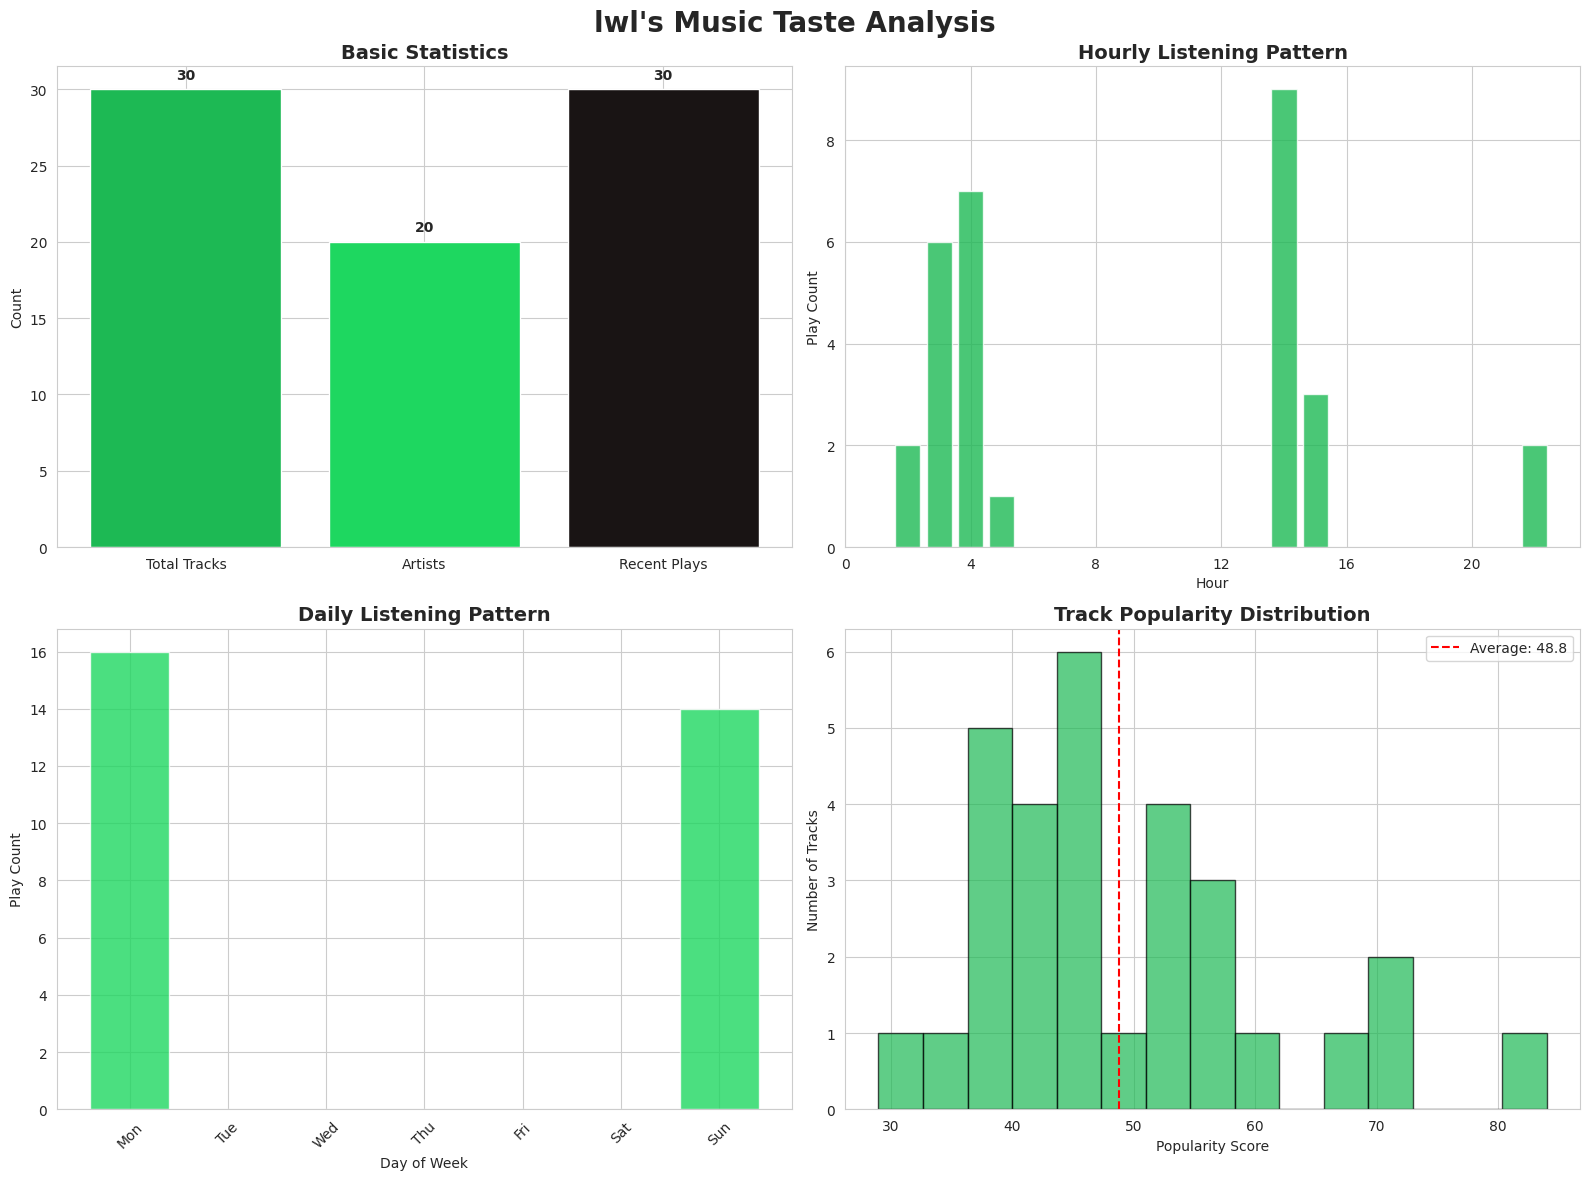

V Summary dashboard displayed


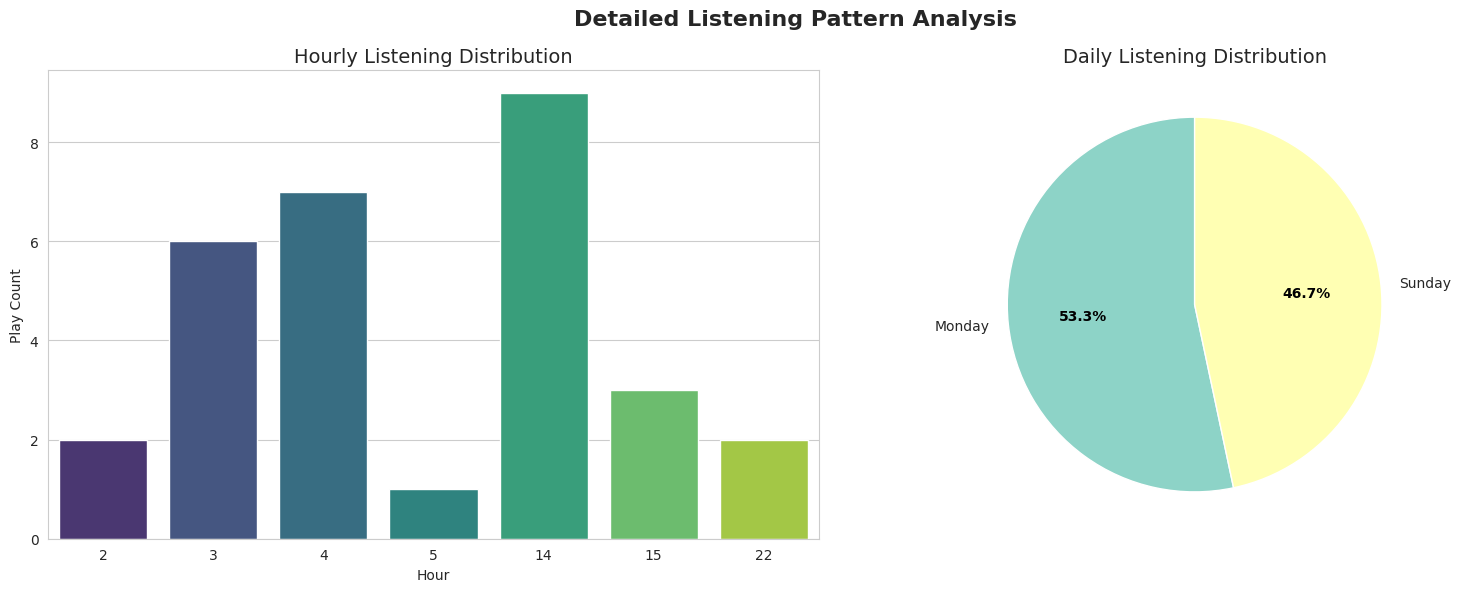

V Detailed listening patterns chart displayed


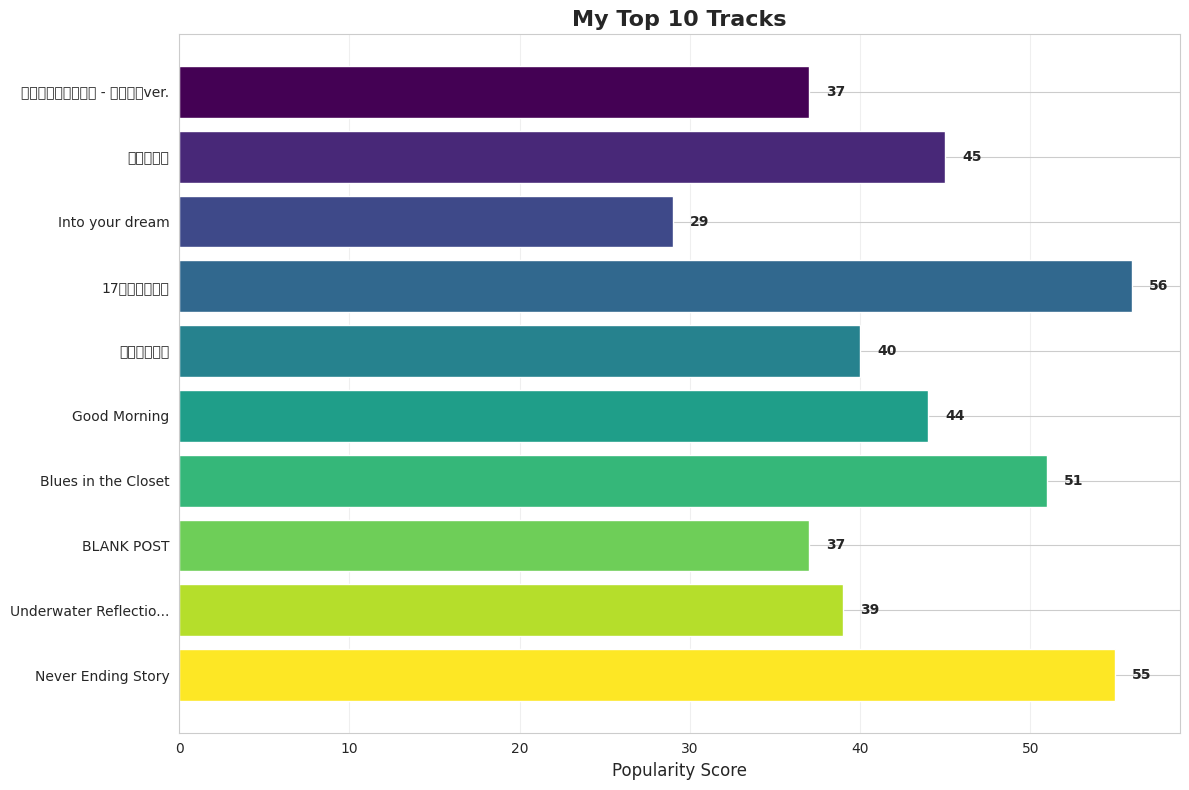

V Top tracks chart displayed


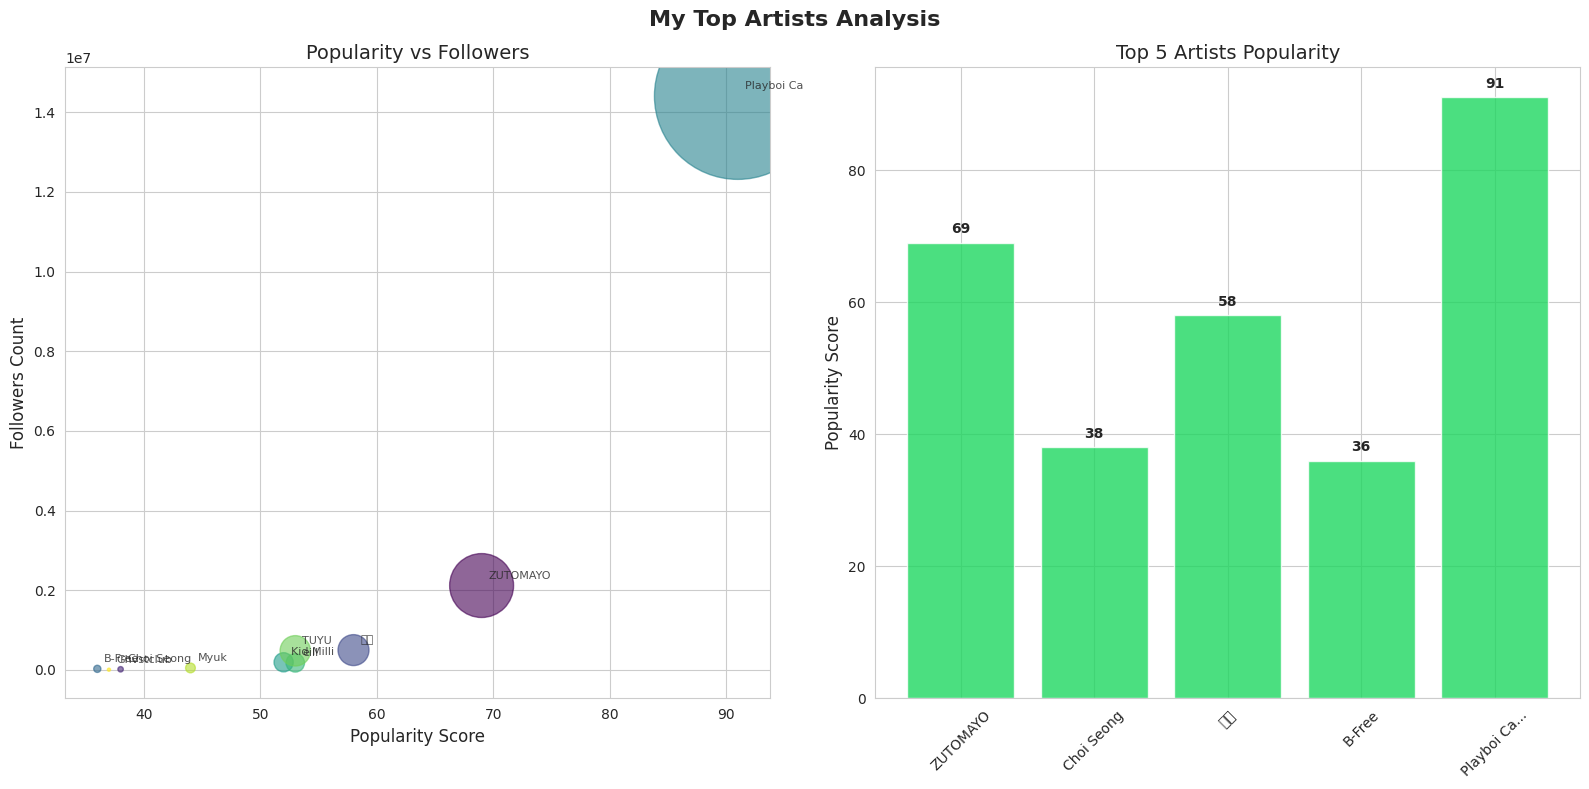

V Artists chart displayed


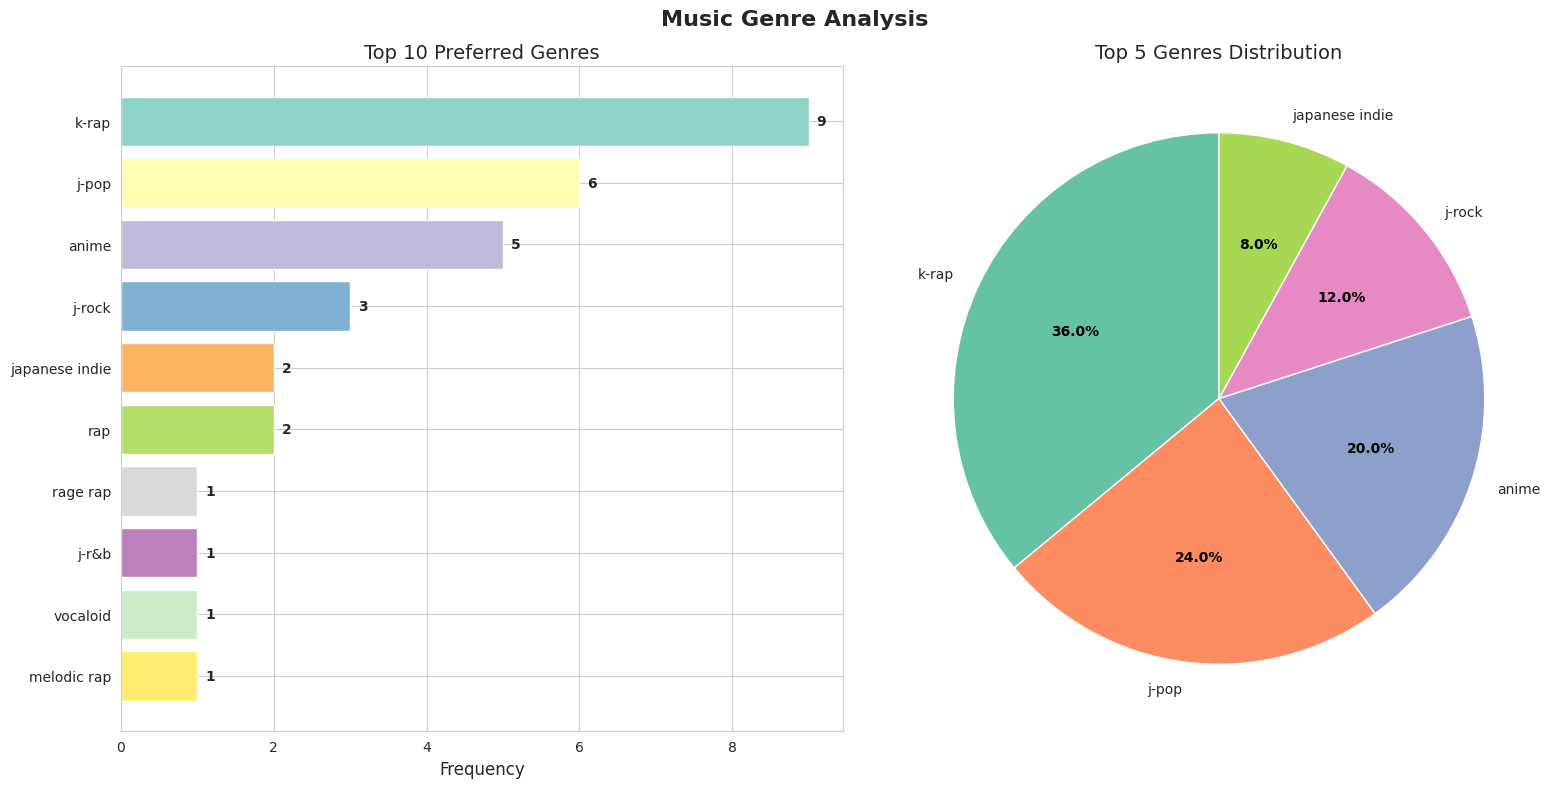

V Genre analysis chart displayed
V All visualizations created

분석 결과 요약
사용자: lwl
분석된 곡: 30개
좋아하는 아티스트: 20명
최근 재생: 30개
평균 인기도: 48.8

청취 패턴:
   가장 많이 듣는 시간: 14시 (9회)
   가장 많이 듣는 요일: 월요일

선호 장르 Top 3:
   1. k-rap: 9개
   2. j-pop: 6개
   3. anime: 5개

Top 5 아티스트:
   1. ZUTOMAYO (인기도: 69)
   2. Choi Seong (인기도: 38)
   3. 美波 (인기도: 58)
   4. B-Free (인기도: 36)
   5. Playboi Carti (인기도: 91)

Top 5 곡:
   1. 曲名はまだないです - 弾き語りver. - Aogumo (인기도: 37)
   2. ろんりねす - ZUTOMAYO (인기도: 45)
   3. Into your dream - eill (인기도: 29)
   4. 17さいのうた。 - 『ユイカ』 (인기도: 56)
   5. タイムグラム - 美波 (인기도: 40)

음악 취향 분석:
   독특하고 개성적인 음악을 선호합니다.
   매우 다양한 장르를 청취합니다.
   점심시간에 활발한 음악 청취 패턴을 보입니다.
   중간 규모의 인기 아티스트들을 주로 청취합니다.
V 모든 분석 완료

분석이 성공적으로 완료되었습니다
생성된 차트들을 확인해보세요


In [ ]:
def main():
    """메인 실행 함수"""
    app = SpotifyAnalyzerApp()
    success = app.run()

    if success:
        print("\n분석이 성공적으로 완료되었습니다")
        print("생성된 차트들을 확인해보세요")
    else:
        print("\n분석 중 오류가 발생했습니다")
        print("설정을 확인하고 다시 시도해주세요")

# 실행 준비
print("Spotify 분석기가 준비되었습니다")
print("Spotify 분석기가 준비되었습니다")
user_input = input("분석을 시작하려면 'ㄱ'을 입력: ")

if user_input.strip() == 'ㄱ':
    main()
else:
    print("분석을 취소했습니다")